In [19]:
### GOAL IS TO PREDICT DIVORCE AMOUNT BY MARRIAGE AMOUNT IN PREVIOUS YEARS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
divorce = pd.read_csv('azhyrasular_kalaauyl_halky.csv')
divorce.head()
df = divorce
df.shape

(614, 76)

In [4]:
df.head()

,terms/0,terms/1,termNames/0,termNames/1,periods/0/name,periods/0/date,periods/0/value,periods/1/name,periods/1/date,periods/1/value,...,periods/20/value,periods/21/name,periods/21/date,periods/21/value,periods/22/name,periods/22/date,periods/22/value,periods/23/name,periods/23/date,periods/23/value
0,741880,533590,РЕСПУБЛИКА КАЗАХСТАН,сельская местность,2019 год,31.12.2019,15715,2018 год,31.12.2018,13675.0,...,11288.0,2021 год,31.12.2021,13414.0,2020 год,31.12.2020,13583.0,2023 год,31.12.2023,10838.0
1,741880,741917,РЕСПУБЛИКА КАЗАХСТАН,Всего,2019 год,31.12.2019,59796,2018 год,31.12.2018,54797.0,...,44517.0,2021 год,31.12.2021,48239.0,2020 год,31.12.2020,48002.0,2023 год,31.12.2023,40227.0
2,258742,741917,КОСТАНАЙСКАЯ ОБЛАСТЬ,Всего,2019 год,31.12.2019,3392,2018 год,31.12.2018,3186.0,...,2412.0,2021 год,31.12.2021,2410.0,2020 год,31.12.2020,2661.0,2023 год,31.12.2023,2324.0
3,256619,741917,КАРАГАНДИНСКАЯ ОБЛАСТЬ,Всего,2019 год,31.12.2019,5386,2018 год,31.12.2018,5154.0,...,3644.0,2021 год,31.12.2021,4717.0,2020 год,31.12.2020,4586.0,2023 год,31.12.2023,3475.0
4,247783,741917,АКМОЛИНСКАЯ ОБЛАСТЬ,Всего,2019 год,31.12.2019,2865,2018 год,31.12.2018,2521.0,...,1804.0,2021 год,31.12.2021,2028.0,2020 год,31.12.2020,2302.0,2023 год,31.12.2023,1422.0


In [5]:
# Create a list of period columns for name, date, and value
period_columns = [f'periods/{i}/name' for i in range(24)] + [f'periods/{i}/date' for i in range(24)] + [f'periods/{i}/value' for i in range(24)]

# Select the metadata columns that need to stay the same across all periods
metadata_columns = ['terms/0', 'terms/1', 'termNames/0', 'termNames/1']

# Filter the dataframe to only include the period and metadata columns
df_periods = df[metadata_columns + period_columns]

# Melt the dataframe to reshape it into long format
df_long = pd.melt(df_periods, id_vars=metadata_columns, var_name='period', value_name='value')

# Extract period index from the 'period' column (e.g., 'periods/0/name' becomes '0')
df_long['period_index'] = df_long['period'].str.extract(r'(\d+)').astype(int)

# Split the 'period' column into 'attribute' (name, date, value) and 'period_index'
df_long['attribute'] = df_long['period'].str.extract(r'(name|date|value)')

# Pivot the table to get 'name', 'date', and 'value' in separate columns
df_final = df_long.pivot_table(index=['terms/0', 'terms/1', 'termNames/0', 'termNames/1', 'period_index'], 
                               columns='attribute', values='value', aggfunc='first').reset_index()

# Rename columns to reflect the structure
df_final.columns.name = None  # Remove the hierarchy from column names
df_final = df_final.rename(columns={'name': 'period_name', 'date': 'period_date', 'value': 'period_value'})

# Show the reshaped dataframe
df_final


,terms/0,terms/1,termNames/0,termNames/1,period_index,period_date,period_name,period_value
0,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,0,31.12.2019,2019 год,1839
1,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,1,31.12.2018,2018 год,1588.0
2,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2,31.12.2009,2009 год,1349.0
3,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,3,31.12.2011,2011 год,1589.0
4,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,4,31.12.2000,2000 год,1006.0
...,...,...,...,...,...,...,...,...
8453,77208142,741917,РАЙОН АҚСУАТ,Всего,1,31.12.2023,2023 год,17.0
8454,77208143,533590,РАЙОН САМАР,сельская местность,0,31.12.2022,2022 год,22
8455,77208143,533590,РАЙОН САМАР,сельская местность,1,31.12.2023,2023 год,22.0
8456,77208143,741917,РАЙОН САМАР,Всего,0,31.12.2022,2022 год,22


In [6]:
df_final[df_final['termNames/0'] == 'РЕСПУБЛИКА КАЗАХСТАН']

,terms/0,terms/1,termNames/0,termNames/1,period_index,period_date,period_name,period_value
7947,741880,533589,РЕСПУБЛИКА КАЗАХСТАН,городская местность,0,31.12.2019,2019 год,44081
7948,741880,533589,РЕСПУБЛИКА КАЗАХСТАН,городская местность,1,31.12.2018,2018 год,41122.0
7949,741880,533589,РЕСПУБЛИКА КАЗАХСТАН,городская местность,2,31.12.2009,2009 год,30163.0
7950,741880,533589,РЕСПУБЛИКА КАЗАХСТАН,городская местность,3,31.12.2011,2011 год,33792.0
7951,741880,533589,РЕСПУБЛИКА КАЗАХСТАН,городская местность,4,31.12.2000,2000 год,22753.0
...,...,...,...,...,...,...,...,...
8014,741880,741917,РЕСПУБЛИКА КАЗАХСТАН,Всего,19,31.12.2017,2017 год,54626.0
8015,741880,741917,РЕСПУБЛИКА КАЗАХСТАН,Всего,20,31.12.2022,2022 год,44517.0
8016,741880,741917,РЕСПУБЛИКА КАЗАХСТАН,Всего,21,31.12.2021,2021 год,48239.0
8017,741880,741917,РЕСПУБЛИКА КАЗАХСТАН,Всего,22,31.12.2020,2020 год,48002.0


In [7]:
df_final.drop(columns = ['terms/0', 'terms/1', 'period_index', 'period_date'], axis = 1, inplace = True)
df_final

,termNames/0,termNames/1,period_name,period_value
0,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2019 год,1839
1,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2018 год,1588.0
2,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2009 год,1349.0
3,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2011 год,1589.0
4,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2000 год,1006.0
...,...,...,...,...
8453,РАЙОН АҚСУАТ,Всего,2023 год,17.0
8454,РАЙОН САМАР,сельская местность,2022 год,22
8455,РАЙОН САМАР,сельская местность,2023 год,22.0
8456,РАЙОН САМАР,Всего,2022 год,22


In [8]:
df_final['District'] = df_final['termNames/0']
df_final['Area'] = df_final['termNames/1']
df_final['Year'] = df_final['period_name']
df_final['Number'] = df_final['period_value']

In [9]:
df_final.drop(columns = ['termNames/0', 'termNames/1', 'period_name', 'period_value'], axis = 1, inplace = True)

In [10]:
divorce = df_final
divorce

,District,Area,Year,Number
0,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2019 год,1839
1,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2018 год,1588.0
2,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2009 год,1349.0
3,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2011 год,1589.0
4,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2000 год,1006.0
...,...,...,...,...
8453,РАЙОН АҚСУАТ,Всего,2023 год,17.0
8454,РАЙОН САМАР,сельская местность,2022 год,22
8455,РАЙОН САМАР,сельская местность,2023 год,22.0
8456,РАЙОН САМАР,Всего,2022 год,22


In [11]:
df = pd.read_csv('nekeler_kalaauyl_halky.csv')
# Create a list of period columns for name, date, and value
period_columns = [f'periods/{i}/name' for i in range(24)] + [f'periods/{i}/date' for i in range(24)] + [f'periods/{i}/value' for i in range(24)]

# Select the metadata columns that need to stay the same across all periods
metadata_columns = ['terms/0', 'terms/1', 'termNames/0', 'termNames/1']

# Filter the dataframe to only include the period and metadata columns
df_periods = df[metadata_columns + period_columns]

# Melt the dataframe to reshape it into long format
df_long = pd.melt(df_periods, id_vars=metadata_columns, var_name='period', value_name='value')

# Extract period index from the 'period' column (e.g., 'periods/0/name' becomes '0')
df_long['period_index'] = df_long['period'].str.extract(r'(\d+)').astype(int)

# Split the 'period' column into 'attribute' (name, date, value) and 'period_index'
df_long['attribute'] = df_long['period'].str.extract(r'(name|date|value)')

# Pivot the table to get 'name', 'date', and 'value' in separate columns
df_final = df_long.pivot_table(index=['terms/0', 'terms/1', 'termNames/0', 'termNames/1', 'period_index'], 
                               columns='attribute', values='value', aggfunc='first').reset_index()

# Rename columns to reflect the structure
df_final.columns.name = None  # Remove the hierarchy from column names
df_final = df_final.rename(columns={'name': 'period_name', 'date': 'period_date', 'value': 'period_value'})

# Show the reshaped dataframe
df_final.head()

,terms/0,terms/1,termNames/0,termNames/1,period_index,period_date,period_name,period_value
0,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,0,31.12.2019,2019 год,3099
1,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,1,31.12.2018,2018 год,3182.0
2,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2,31.12.2009,2009 год,3476.0
3,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,3,31.12.2011,2011 год,3612.0
4,247783,533589,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,4,31.12.2000,2000 год,2395.0


In [12]:
df_final.drop(columns = ['terms/0', 'terms/1', 'period_index', 'period_date'], axis = 1, inplace = True)

In [13]:
df_final.head()

,termNames/0,termNames/1,period_name,period_value
0,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2019 год,3099
1,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2018 год,3182.0
2,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2009 год,3476.0
3,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2011 год,3612.0
4,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2000 год,2395.0


In [14]:
df_final['District'] = df_final['termNames/0']
df_final['Area'] = df_final['termNames/1']
df_final['Year'] = df_final['period_name']
df_final['Number'] = df_final['period_value'].astype(int)

In [15]:
df_final.drop(columns = ['termNames/0', 'termNames/1', 'period_name', 'period_value'], axis = 1, inplace = True)

In [16]:
marriage = df_final
marriage.head()

,District,Area,Year,Number
0,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2019 год,3099
1,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2018 год,3182
2,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2009 год,3476
3,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2011 год,3612
4,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2000 год,2395


In [17]:
marriage.to_csv('marriage.csv')
divorce.to_csv('divorce.csv')

In [18]:
divorce[divorce['Year'] == '2020 год']

,District,Area,Year,Number
22,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2020 год,1481.0
46,АКМОЛИНСКАЯ ОБЛАСТЬ,сельская местность,2020 год,821.0
70,АКМОЛИНСКАЯ ОБЛАСТЬ,Всего,2020 год,2302.0
85,КОКШЕТАУ Г.А.,городская местность,2020 год,680.0
99,КОКШЕТАУ Г.А.,сельская местность,2020 год,48.0
...,...,...,...,...
8392,ЖЕТЫСАЙСКИЙ РАЙОН,городская местность,2020 год,99.0
8399,ЖЕТЫСАЙСКИЙ РАЙОН,сельская местность,2020 год,112.0
8406,ЖЕТЫСАЙСКИЙ РАЙОН,Всего,2020 год,211.0
8413,КЕЛЕССКИЙ РАЙОН,сельская местность,2020 год,134.0


In [19]:
divorce['Year'] = pd.to_datetime(divorce['Year'].str.extract(r'(\d{4})')[0], format='%Y')
marriage['Year'] = pd.to_datetime(marriage['Year'].str.extract(r'(\d{4})')[0], format='%Y')

# Merge datasets on District, Area, and Year
merged_df = pd.merge(divorce, marriage, on=['District', 'Area', 'Year'], suffixes=('_Divorce', '_Marriage'))


In [58]:
data = merged_df
data.head()

,District,Area,Year,Number_Divorce,Number_Marriage,Marriages_t-1
0,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2019-01-01,1839,3099,NaN
1,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2018-01-01,1588.0,3182,3099.0
2,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2009-01-01,1349.0,3476,3182.0
3,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2011-01-01,1589.0,3612,3476.0
4,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2000-01-01,1006.0,2395,3612.0


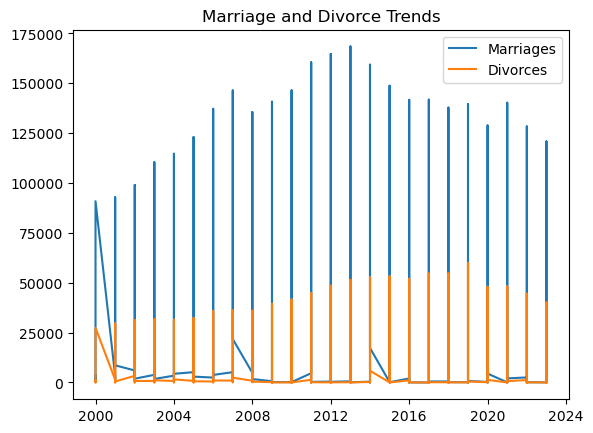

In [64]:
data.sort_values('Year', inplace=True)
plt.plot(data['Year'], data['Number_Marriage'], label='Marriages')
plt.plot(data['Year'], data['Number_Divorce'], label='Divorces')
plt.legend()
plt.title('Marriage and Divorce Trends')
plt.show()


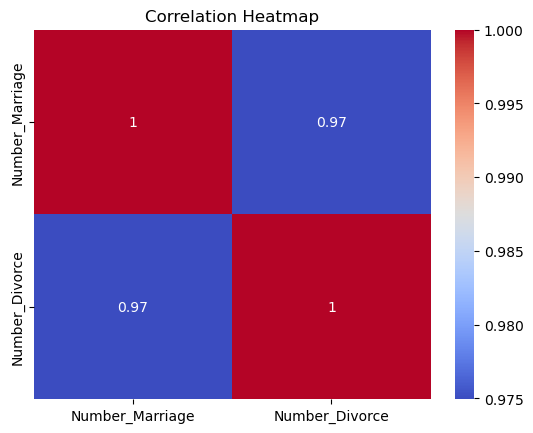

In [68]:
sns.heatmap(data[['Number_Marriage', 'Number_Divorce']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

/var/folders/nr/vzg49d414hbc6hjpmy2v0ctr0000gn/T/ipykernel_20224/1004017456.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_marriages, x='Number_Marriage', y='District', palette='Blues_r')


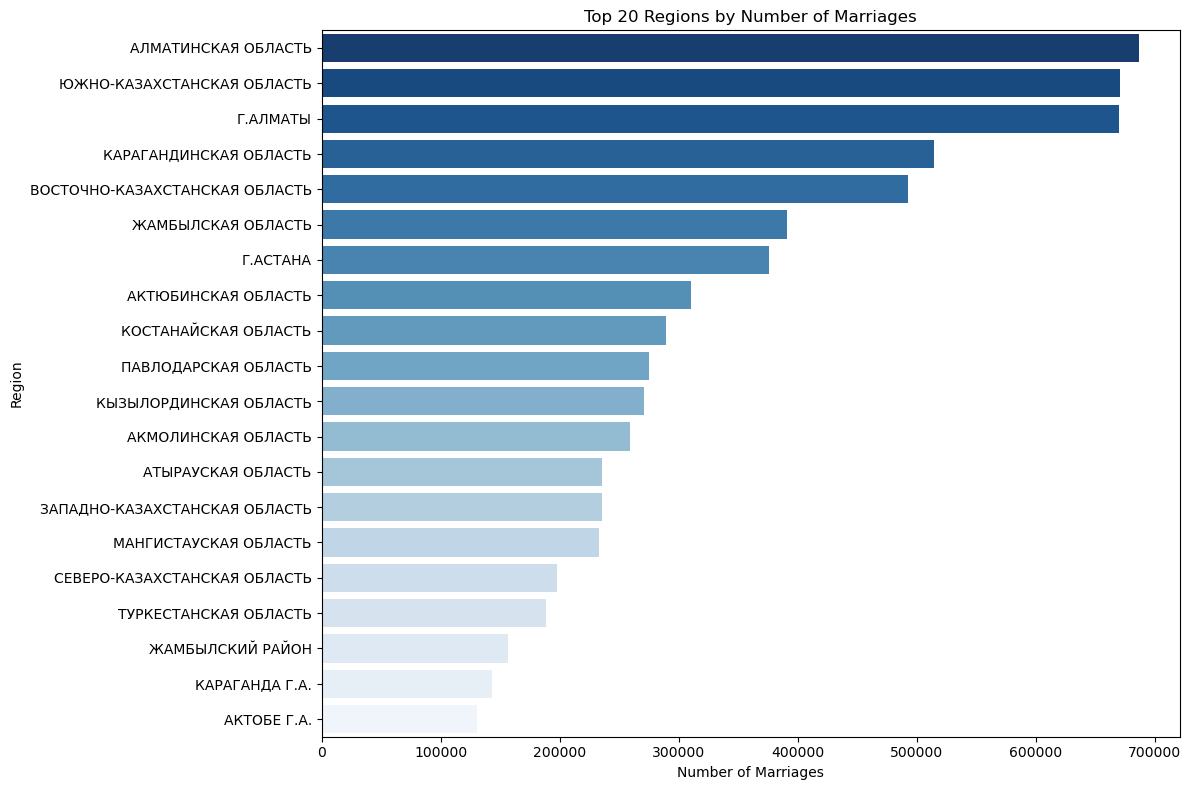

/var/folders/nr/vzg49d414hbc6hjpmy2v0ctr0000gn/T/ipykernel_20224/1004017456.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_divorces, x='Number_Divorce', y='District', palette='Reds_r')


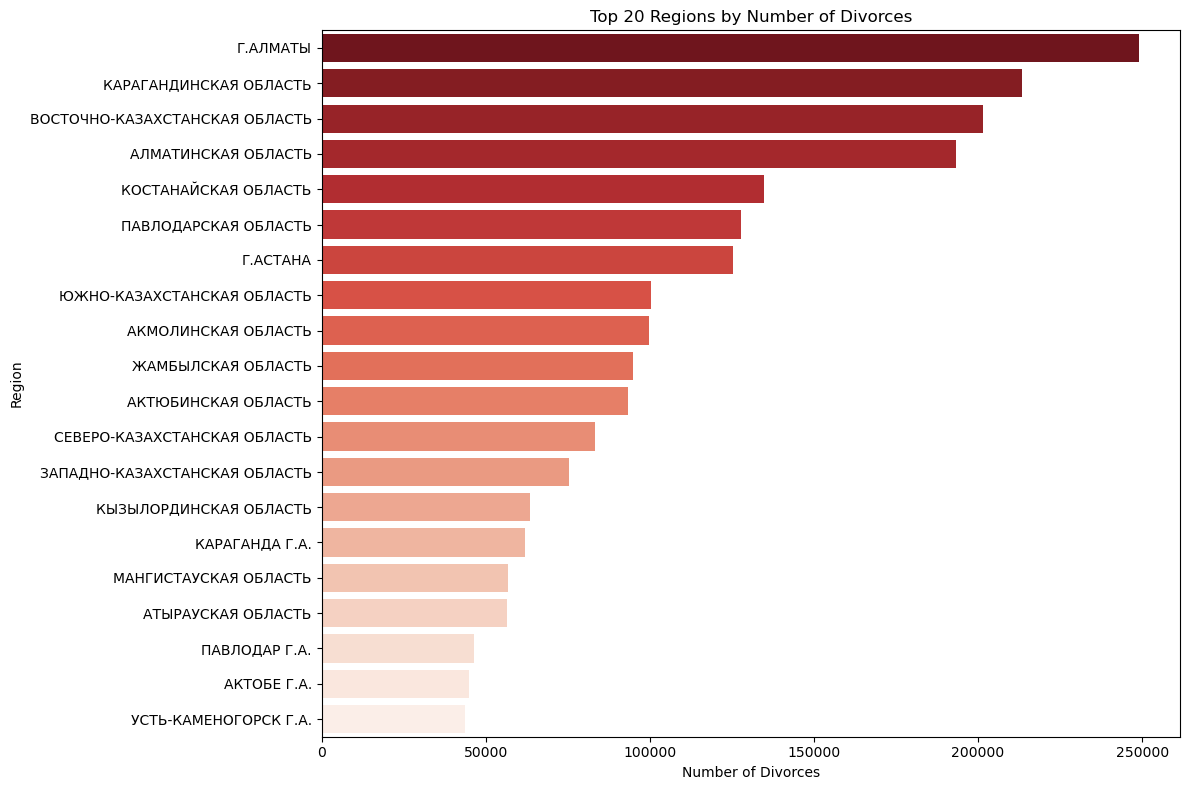

In [22]:
# Aggregate data by district
dat = data[data['District'] != 'РЕСПУБЛИКА КАЗАХСТАН']
region_data = dat.groupby('District')[['Number_Divorce', 'Number_Marriage']].sum().reset_index()

# Top 20 regions for marriages
top_20_marriages = region_data.sort_values(by='Number_Marriage', ascending=False).head(20)

# Top 20 regions for divorces
top_20_divorces = region_data.sort_values(by='Number_Divorce', ascending=False).head(20)

# Plot: Top 20 Regions for Marriages
plt.figure(figsize=(12, 8))
sns.barplot(data=top_20_marriages, x='Number_Marriage', y='District', palette='Blues_r')
plt.title('Top 20 Regions by Number of Marriages')
plt.xlabel('Number of Marriages')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

# Plot: Top 20 Regions for Divorces
plt.figure(figsize=(12, 8))
sns.barplot(data=top_20_divorces, x='Number_Divorce', y='District', palette='Reds_r')
plt.title('Top 20 Regions by Number of Divorces')
plt.xlabel('Number of Divorces')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


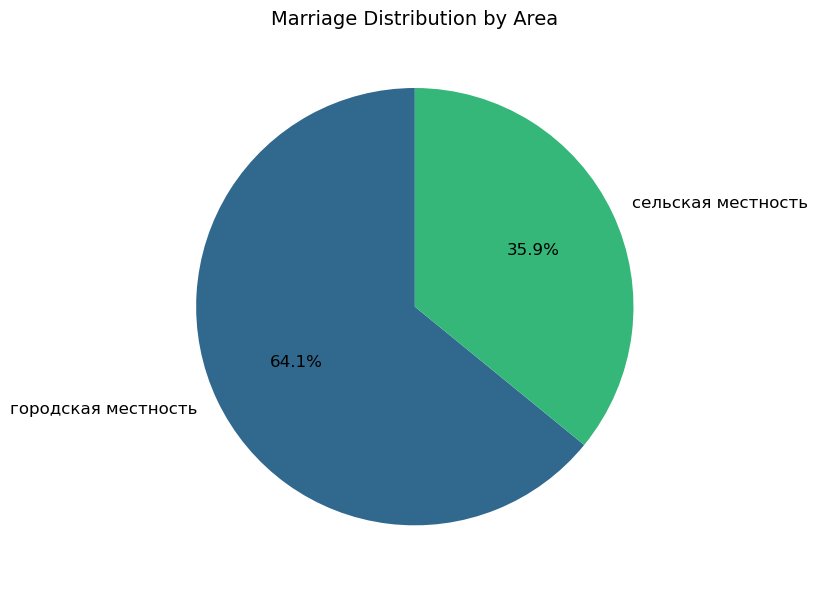

/var/folders/nr/vzg49d414hbc6hjpmy2v0ctr0000gn/T/ipykernel_20224/3964096834.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  area_data['Number_Divorce'].plot.pie(


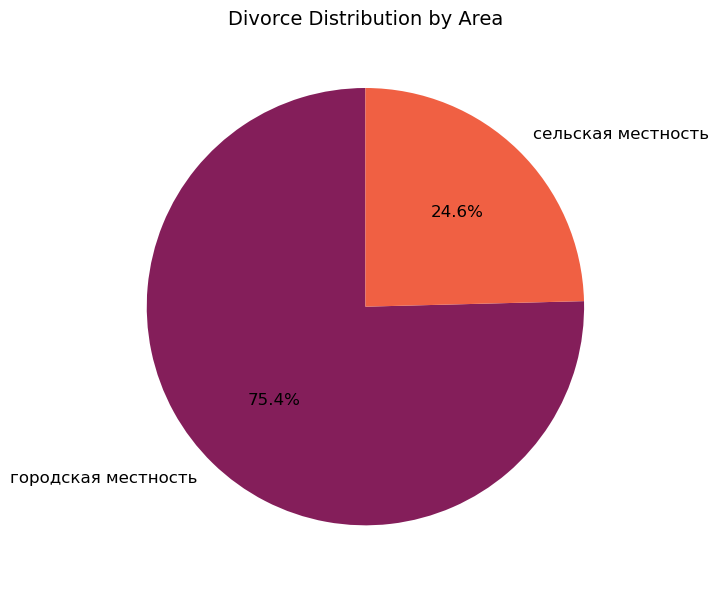

In [23]:
# Aggregate data by area
dat = data[data['Area'] != 'Всего']
area_data = dat.groupby('Area')[['Number_Divorce', 'Number_Marriage']].sum()

# Plot pie chart for marriages
plt.figure(figsize=(8, 6))
area_data['Number_Marriage'].plot.pie(
    autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(area_data)), textprops={'fontsize': 12})

plt.title('Marriage Distribution by Area', fontsize=14)
plt.ylabel('')  # Removes the y-label
plt.tight_layout()
plt.show()

# Plot pie chart for divorces
plt.figure(figsize=(8, 6))
area_data['Number_Divorce'].plot.pie(
    autopct='%1.1f%%', startangle=90, colors=sns.color_palette('rocket', len(area_data)), textprops={'fontsize': 12}
)
plt.title('Divorce Distribution by Area', fontsize=14)
plt.ylabel('')  # Removes the y-label
plt.tight_layout()
plt.show()


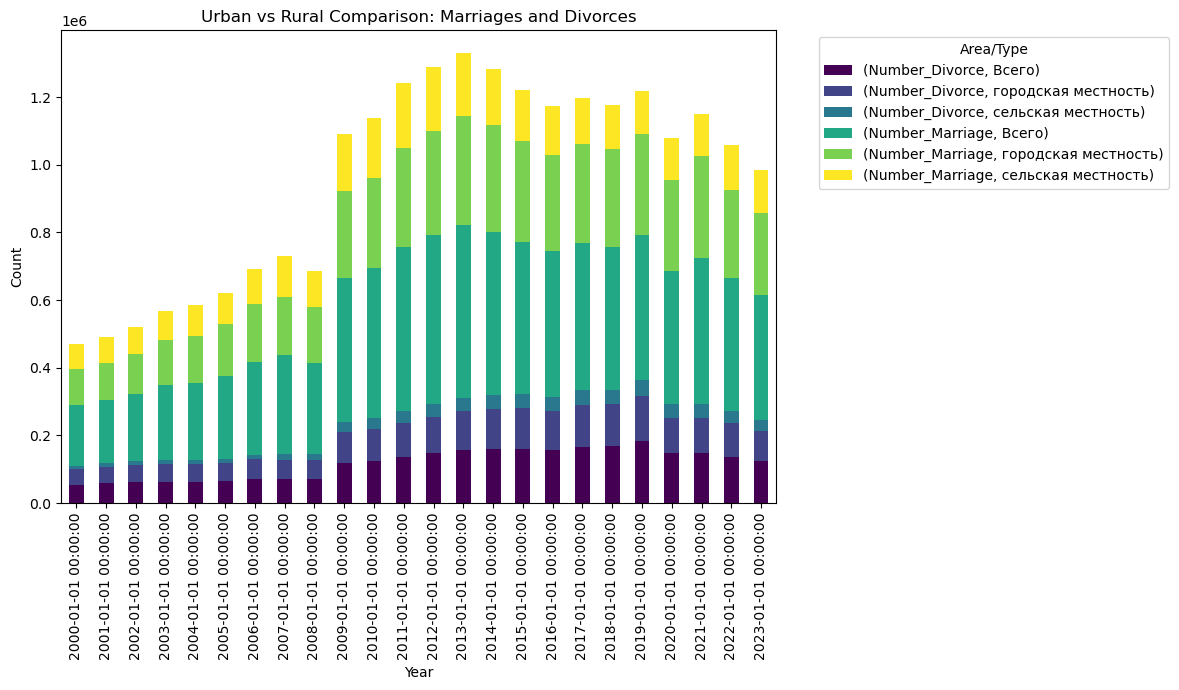

In [26]:
# Group by area and year
area_data = data.groupby(['Year', 'Area'])[['Number_Divorce', 'Number_Marriage']].sum().unstack('Area')

# Plot
area_data.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Urban vs Rural Comparison: Marriages and Divorces')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Area/Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


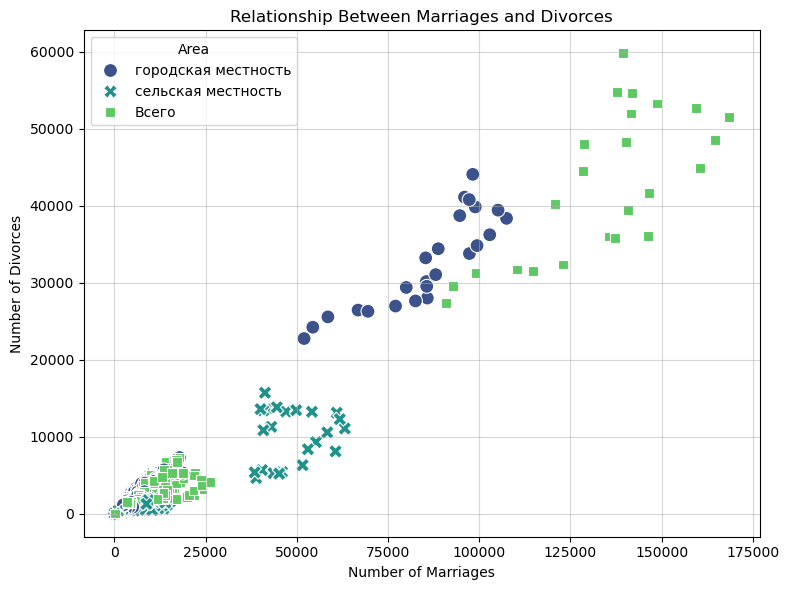

In [28]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Number_Marriage', y='Number_Divorce', hue='Area', style='Area', palette='viridis', s=100)
plt.title('Relationship Between Marriages and Divorces')
plt.xlabel('Number of Marriages')
plt.ylabel('Number of Divorces')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [35]:
data['Marriages_t-1'] = data.groupby(['District', 'Area'])['Number_Marriage'].shift(1)
data = data.dropna()

In [46]:
data

,District,Area,Year,Number_Divorce,Number_Marriage,Marriages_t-1
1,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2018-01-01,1588.0,3182,3099.0
2,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2009-01-01,1349.0,3476,3182.0
3,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2011-01-01,1589.0,3612,3476.0
4,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2000-01-01,1006.0,2395,3612.0
5,АКМОЛИНСКАЯ ОБЛАСТЬ,городская местность,2005-01-01,1292.0,3060,2395.0
...,...,...,...,...,...,...
8815,ОБЛАСТЬ АБАЙ,Всего,2023-01-01,1514.0,3452,3726.0
8817,РАЙОН АҚСУАТ,сельская местность,2023-01-01,17.0,69,103.0
8819,РАЙОН АҚСУАТ,Всего,2023-01-01,17.0,69,103.0
8821,РАЙОН САМАР,сельская местность,2023-01-01,22.0,61,38.0


In [47]:
# One-Hot Encode 'District' and 'Area'
ohe = OneHotEncoder(sparse_output=False)
categorical_features = ohe.fit_transform(data[['District', 'Area']])

# Combine encoded features with lagged marriages
features = np.hstack([categorical_features, data[['Marriages_t-1']].values])

# Convert features to float32
features = features.astype(np.float32)

# Normalize the target variable
scaler = MinMaxScaler()
targets = scaler.fit_transform(data[['Number_Divorce']].values)

# Convert targets to float32
targets = targets.astype(np.float32)

In [49]:

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Prevent overfitting
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - loss: 25428.8438 - val_loss: 3248.5938
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 2840.5996 - val_loss: 42.3111
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 1910.7352 - val_loss: 95.9519
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 762.5632 - val_loss: 0.1895
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 361.2565 - val_loss: 0.2787
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 166.5341 - val_loss: 0.0121
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 178.1248 - val_loss: 25.5641
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 40.5225 - val_loss: 0.3925
Epoch 9/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 57.0168 - val_loss: 0.2585
Epoch 10/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 23.3162 - val_loss: 0.0396
Epoch 11/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 11.5491 - val_loss: 1.2938
Epoch 12/50
2

In [52]:
def predict_divorce(region, area, marriages):
    # Create a DataFrame for the new data with the same column names as used during fitting
    input_df = pd.DataFrame([[region, area]], columns=['District', 'Area'])
    
    # Encode user input for District and Area
    input_categorical = ohe.transform(input_df).astype(np.float32)
    
    # Combine with lagged marriages
    input_features = np.hstack([input_categorical, [[marriages]]]).astype(np.float32)
    
    # Reshape for LSTM
    input_features = input_features.reshape((1, 1, input_features.shape[1]))
    
    # Predict and inverse transform
    divorce_norm = model.predict(input_features, verbose=0)
    divorce = scaler.inverse_transform([[divorce_norm[0][0]]])[0][0]
    return divorce


In [ ]:
import numpy as np

while True:
    user_region = input("Enter region: ")
    user_area = input("Enter type of area: ")
    user_marriages = float(input("Enter number of marriages for the previous year: "))
    
    if user_region.lower() == 'exit':
        break
    
    # Get the predicted divorce
    predicted_divorce = predict_divorce(user_region, user_area, user_marriages)
    
    # Check if the predicted value is NaN
    if np.isnan(predicted_divorce):
        print("Prediction could not be made. Please check your input values.")
    else:
        predicted_divorce_int = int(predicted_divorce)  # Convert to integer
        print(f"Predicted divorces for this year in {user_region} ({user_area}): {predicted_divorce_int}")


Enter region:  РЕСПУБЛИКА КАЗАХСТАН
Enter type of area:  Всего
Enter number of marriages for the previous year:  10000


Predicted divorces for this year in РЕСПУБЛИКА КАЗАХСТАН (Всего): 2788
